# Preprocessing

## Imports

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, matthews_corrcoef, f1_score

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import kagglehub

## Download data

In [3]:
# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

100%|██████████| 612M/612M [00:05<00:00, 115MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


## Define paths

In [4]:
train_dir = path+'/train/'
test_dir = path+'/test/'
val_dir = path+'/val/'

class_names = os.listdir(train_dir)

## Make folders for test and validation

In [5]:
for class_name in class_names:
    if not os.path.exists(test_dir+class_name):
        os.makedirs(test_dir+class_name)
    if not os.path.exists(val_dir+class_name):
        os.makedirs(val_dir+class_name)

In [6]:
test_meta_df = pd.read_csv(path+'/Test.csv')
test_meta_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [7]:
for i in range(test_meta_df.shape[0]):
    folder = test_meta_df.iloc[i]['ClassId']
    filename = test_meta_df.iloc[i]['Path'].split('/')[-1]
    if os.path.exists(test_dir+filename):
        shutil.move(test_dir+filename, test_dir+str(folder)+'/'+filename)

In [8]:
train_meta_df = pd.read_csv(path+'/Train.csv')
train_meta_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [9]:
val_meta_df = train_meta_df.sample(round(train_meta_df.shape[0]*0.1))
for i in range(val_meta_df.shape[0]):
    folder = val_meta_df.iloc[i]['ClassId']
    filename = val_meta_df.iloc[i]['Path'].split('/')[-1]
    if os.path.exists(train_dir+str(folder)+'/'+filename):
        shutil.move(train_dir+str(folder)+'/'+filename, val_dir+str(folder)+'/'+filename)

# Exploratory analysis

## Plot one example for each class

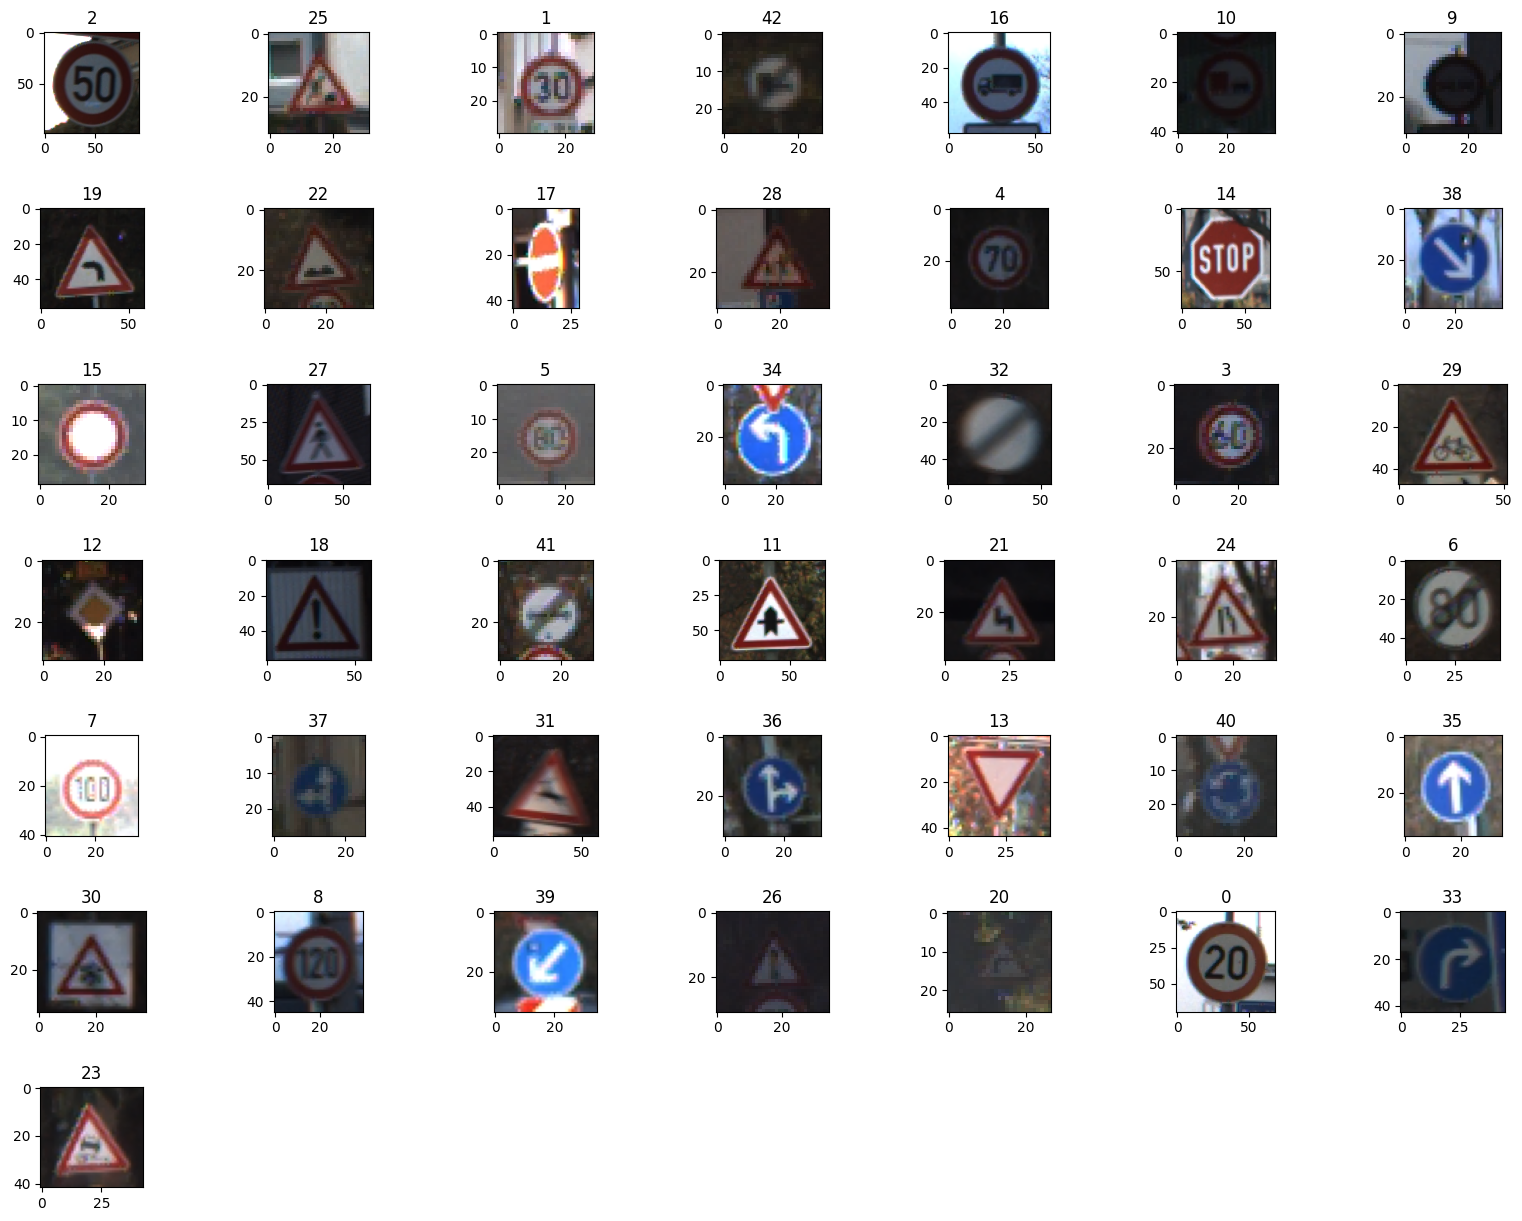

In [10]:
plt.figure(figsize=(20,15))
for fold, i in zip(class_names,range(len(class_names))):
    plt.subplot(7,7,i+1)
    img_read = plt.imread(train_dir+fold+'/'+os.listdir(train_dir+fold)[0])
    plt.imshow(img_read)
    plt.title(class_names[i])

plt.subplots_adjust(hspace=0.75)
plt.show()

In [11]:
df = pd.read_csv(path+'/Train.csv')
print(df.shape)
df.head()

(39209, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


## Plot histogram

<Axes: xlabel='ClassId', ylabel='Count'>

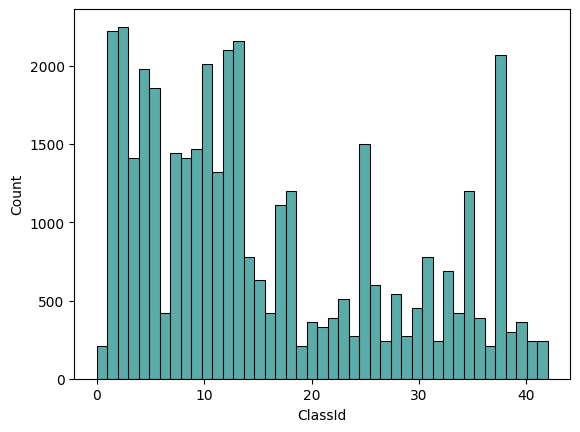

In [12]:
sns.histplot(data=df, x='ClassId', color=sns.palettes.color_palette('viridis',1)[0], bins=43)

# Setup data

## Prepare data

In [13]:
train_datagen = ImageDataGenerator(rescale = 1./255., samplewise_center=True, samplewise_std_normalization=True)
test_datagen =  ImageDataGenerator(rescale = 1./255., samplewise_center=True, samplewise_std_normalization=True)
val_datagen =  ImageDataGenerator(rescale = 1./255., samplewise_center=True, samplewise_std_normalization=True)

batch_size = 128

In [14]:
img_shape = (32,32)
train_gen = train_datagen.flow_from_directory(train_dir, batch_size=batch_size, classes=class_names, class_mode='categorical',
                                          shuffle=True, target_size=img_shape, seed=42)
val_gen = val_datagen.flow_from_directory(val_dir, batch_size=batch_size, classes=class_names, class_mode='categorical',
                                      shuffle=True, target_size=img_shape, seed=42)
test_gen = test_datagen.flow_from_directory(test_dir, batch_size=batch_size, classes=class_names, class_mode='categorical',
                                        shuffle=False, target_size=img_shape, seed=42)

Found 35288 images belonging to 43 classes.
Found 3921 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


# Model from scratch

## Model

In [15]:
model = models.Sequential()

model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='valid', strides=(2,2), activation = 'tanh', input_shape=(img_shape[0], img_shape[1], 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3,3), padding='valid', strides=(2,2), activation = 'tanh'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(len(class_names), activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 15, 15, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 15, 15, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 43)                  │           5,547 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 157,739 (616.17 KB)

 Trainable params: 157,227 (614.17 KB)

 Non-trainable params: 512 (2.00 KB)

## Train

In [16]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6, min_delta=1e-3)

history= model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=[early_stopping,reduce_lr])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


276/276 ━━━━━━━━━━━━━━━━━━━━ 31s 91ms/step - accuracy: 0.3552 - loss: 2.3454 - val_accuracy: 0.6236 - val_loss: 1.1997 - learning_rate: 0.0100
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 35s 83ms/step - accuracy: 0.6930 - loss: 0.9796 - val_accuracy: 0.7529 - val_loss: 0.7762 - learning_rate: 0.0100
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.7651 - loss: 0.7325 - val_accuracy: 0.7508 - val_loss: 0.8070 - learning_rate: 0.0100
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.8045 - loss: 0.6166 - val_accuracy: 0.8110 - val_loss: 0.6269 - learning_rate: 0.0100
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - accuracy: 0.8333 - loss: 0.5337 - val_accuracy: 0.8319 - val_loss: 0.5418 - learning_rate: 0.0100
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 23s 82ms/step - accuracy: 0.8508 - loss: 0.4778 - val_accuracy: 0.8276 - val_loss: 0.5569 - learning_rate: 0.0100
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.8462 - loss: 0.4808

## History

Text(0.5, 0, 'epoch')

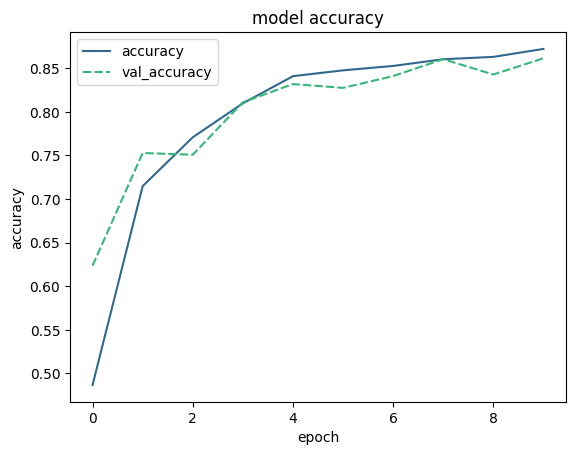

In [17]:
hist = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
sns.lineplot(hist, palette='viridis')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

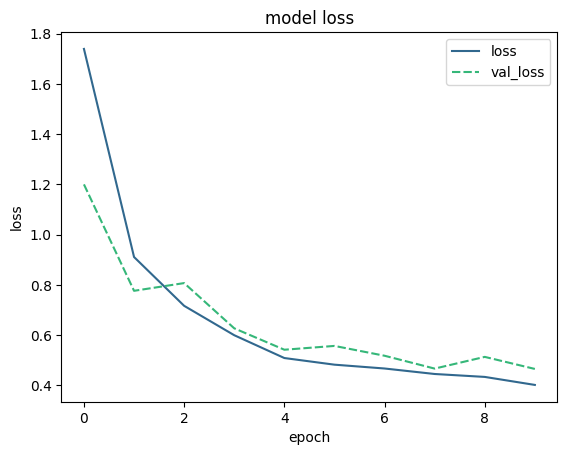

In [18]:
hist = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
sns.lineplot(hist, palette='viridis')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

## Test results

In [19]:
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_test = test_gen.classes

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step


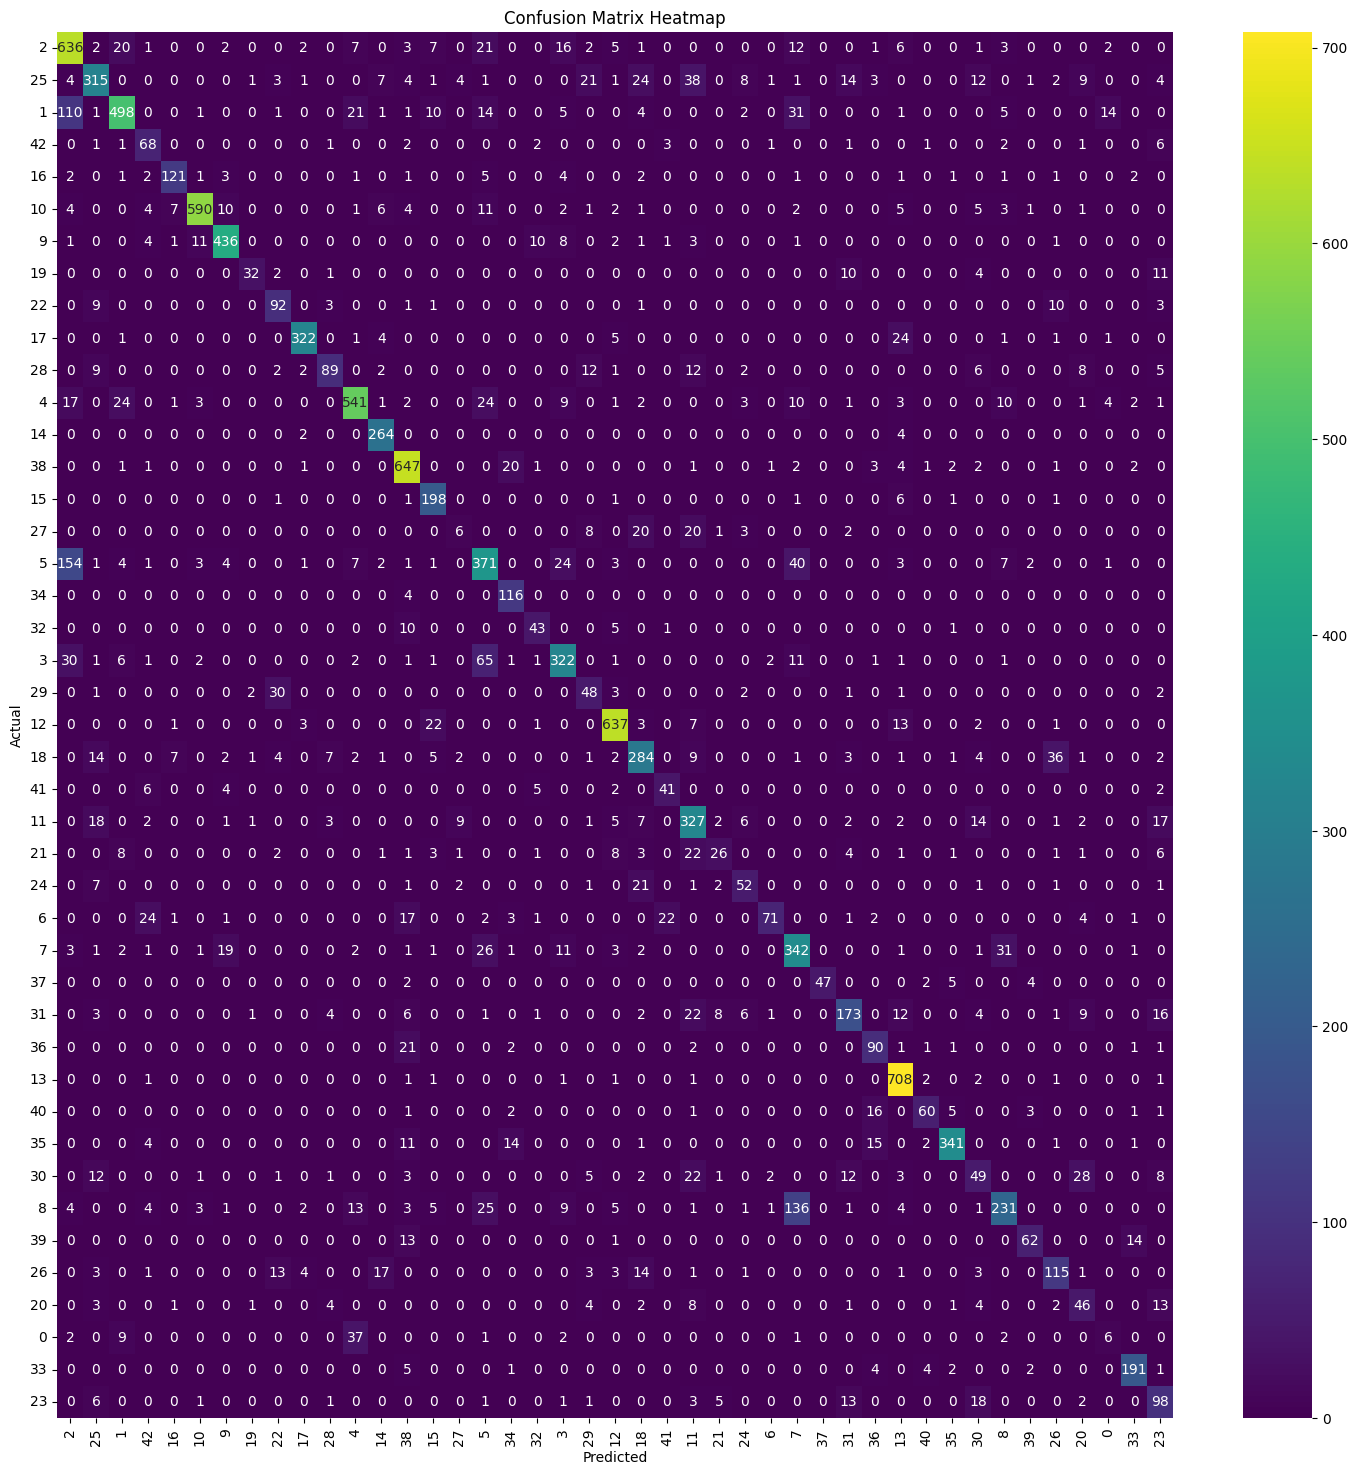

-Test Accuracy: 77.21%
-Train Accuracy: 87.23%
-Accuracy by validation: 86.15%
-Test F1 Macro: 0.70
-Test MCC: 0.76


In [20]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(18,18))
heatmap = sns.heatmap(conf_mat, vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True, fmt='d',cmap='viridis')
heatmap.set_title('Confusion Matrix Heatmap')
heatmap.set_xlabel('Predicted')
heatmap.set_ylabel('Actual')
heatmap.set_xticklabels(class_names, rotation=90)
heatmap.set_yticklabels(class_names, rotation=0)
plt.show()

print('-Test Accuracy: {:.2f}%\n-Train Accuracy: {:.2f}%\n-Accuracy by validation: {:.2f}%\n-Test F1 Macro: {:.2f}\n-Test MCC: {:.2f}'.
      format(accuracy_score(y_test,y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100, f1_score(y_test,y_pred, average='macro'), matthews_corrcoef(y_test,y_pred)))

## Visualize errors

In [21]:
index=0
index_errors= []

for label, predict in zip(y_test,y_pred):
    if label != predict:
        index_errors.append(index)
    index += 1

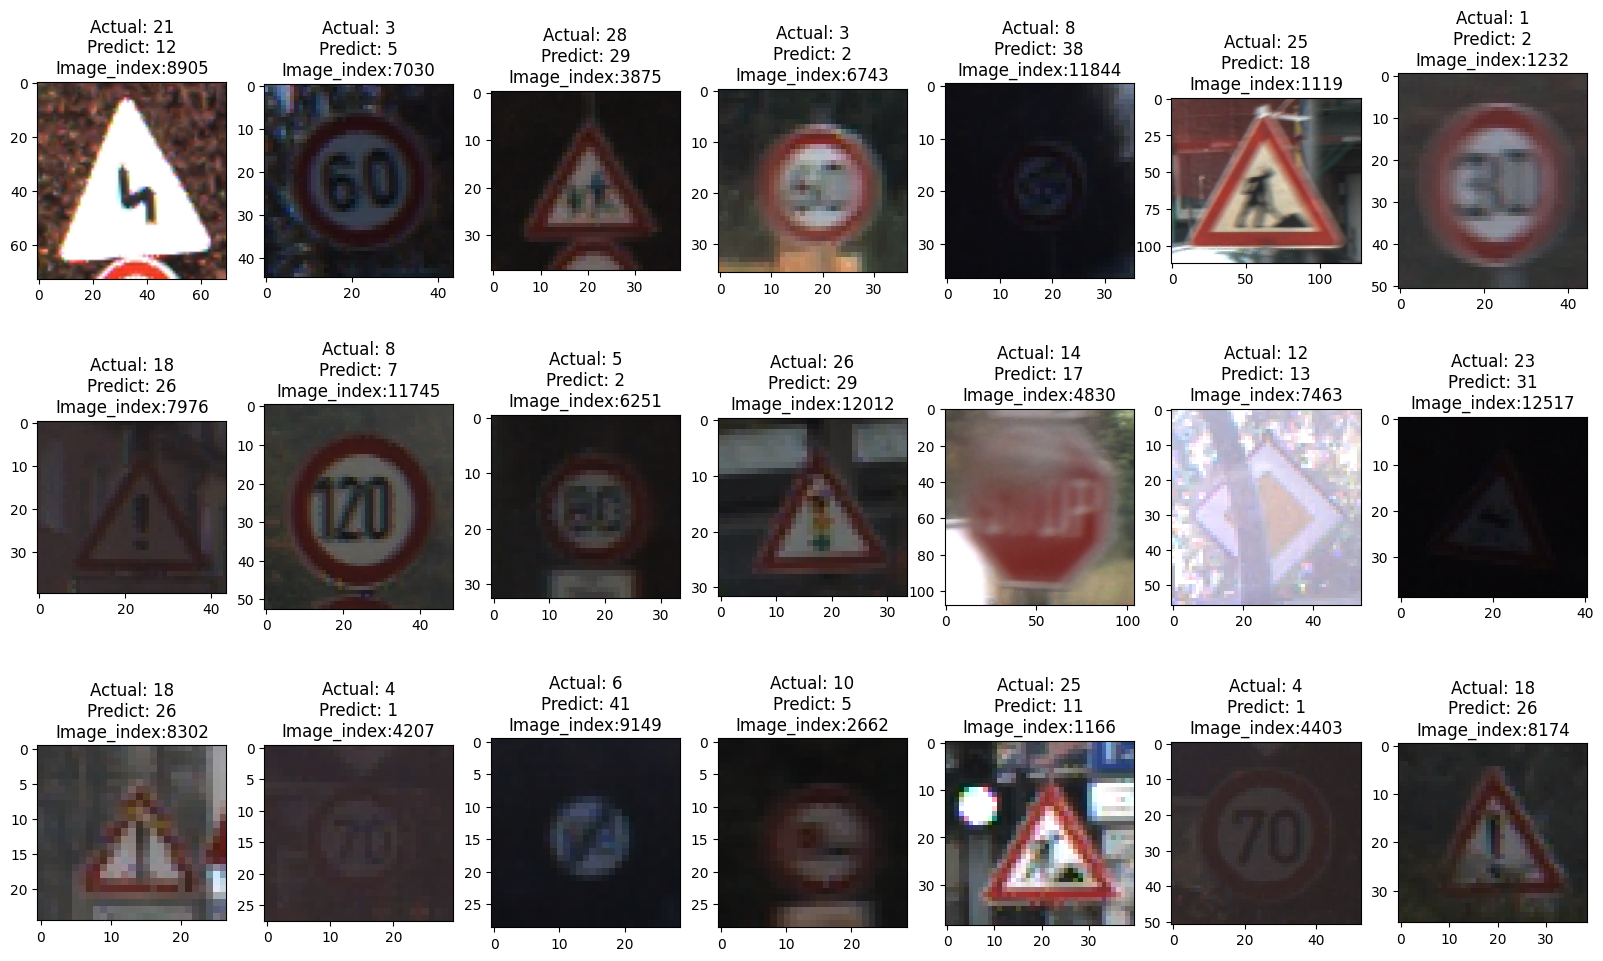

In [22]:
plt.figure(figsize=(20,12))

for i,img_index in zip(range(1,22),random.sample(index_errors,k=21)):
    plt.subplot(3,7,i)
    img_read = plt.imread(test_gen.filepaths[img_index])
    plt.imshow(img_read)
    plt.title('Actual: '+str(class_names[y_test[img_index]])+'\nPredict: '+str(class_names[y_pred[img_index]])+'\nImage_index:'+str(img_index))
plt.show()

# Using an CNN architecture and transfer learning

## Model

In [23]:
def get_model(base_model, hidden_layers, activation, output, output_activation, dropout=None, freeze_base_model=True):
    # freeze layers
    for lys in base_model.layers:
                lys.trainable = not freeze_base_model
    mdl = base_model.output

    for hl in hidden_layers:
        mdl = tf.keras.layers.Dense(hl, activation=activation)(mdl)
    if dropout:
        mdl = tf.keras.layers.Dropout(dropout)(mdl)
    mdl = tf.keras.layers.Dense(output, activation=output_activation)(mdl)
    model = tf.keras.models.Model(base_model.input, mdl)
    return model

In [24]:
model = tf.keras.applications.DenseNet121(input_shape=(img_shape[0], img_shape[1], 3), include_top=False, weights='imagenet', pooling='max')
model = get_model(model, [256], 'relu', len(class_names), 'sigmoid', freeze_base_model=False)
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 38, 38, 3)      │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 8, 8, 64)       │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 8, 8, 64)       │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 128)      │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 128)      │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 128)      │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 32)       │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 8, 8, 96)       │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,310,955 (27.89 MB)

 Trainable params: 7,227,307 (27.57 MB)

 Non-trainable params: 83,648 (326.75 KB)

## Train

In [25]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6, min_delta=1e-3)

history= model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=[early_stopping,reduce_lr])

Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 245s 410ms/step - accuracy: 0.1135 - loss: 3.3974 - val_accuracy: 0.0839 - val_loss: 18.9380 - learning_rate: 0.0100
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 46s 102ms/step - accuracy: 0.4625 - loss: 1.3392 - val_accuracy: 0.2091 - val_loss: 7.0755 - learning_rate: 0.0100
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.6289 - loss: 0.7490 - val_accuracy: 0.3800 - val_loss: 0.9713 - learning_rate: 0.0100
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 41s 97ms/step - accuracy: 0.6725 - loss: 0.5282 - val_accuracy: 0.3213 - val_loss: 2.8768 - learning_rate: 0.0100
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 27s 96ms/step - accuracy: 0.7375 - loss: 0.2771 - val_accuracy: 0.5567 - val_loss: 0.4774 - learning_rate: 0.0100
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 27s 97ms/step - accuracy: 0.7367 - loss: 0.2850 - val_accuracy: 0.0477 - val_loss: 4.7928 - learning_rate: 0.0100
Epoch 7/10
275/276 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7413 

## History

Text(0.5, 0, 'epoch')

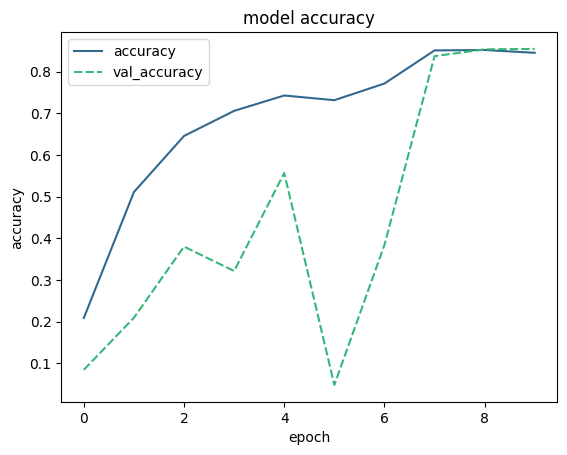

In [26]:
hist = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
sns.lineplot(hist, palette='viridis')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

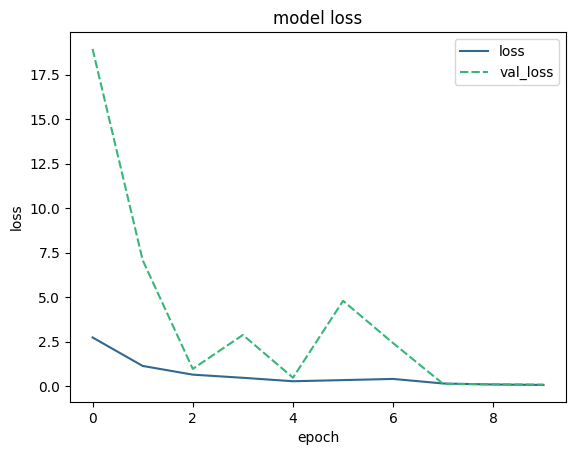

In [27]:
hist = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
sns.lineplot(hist, palette='viridis')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

## Test results

In [28]:
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_test = test_gen.classes

99/99 ━━━━━━━━━━━━━━━━━━━━ 26s 191ms/step


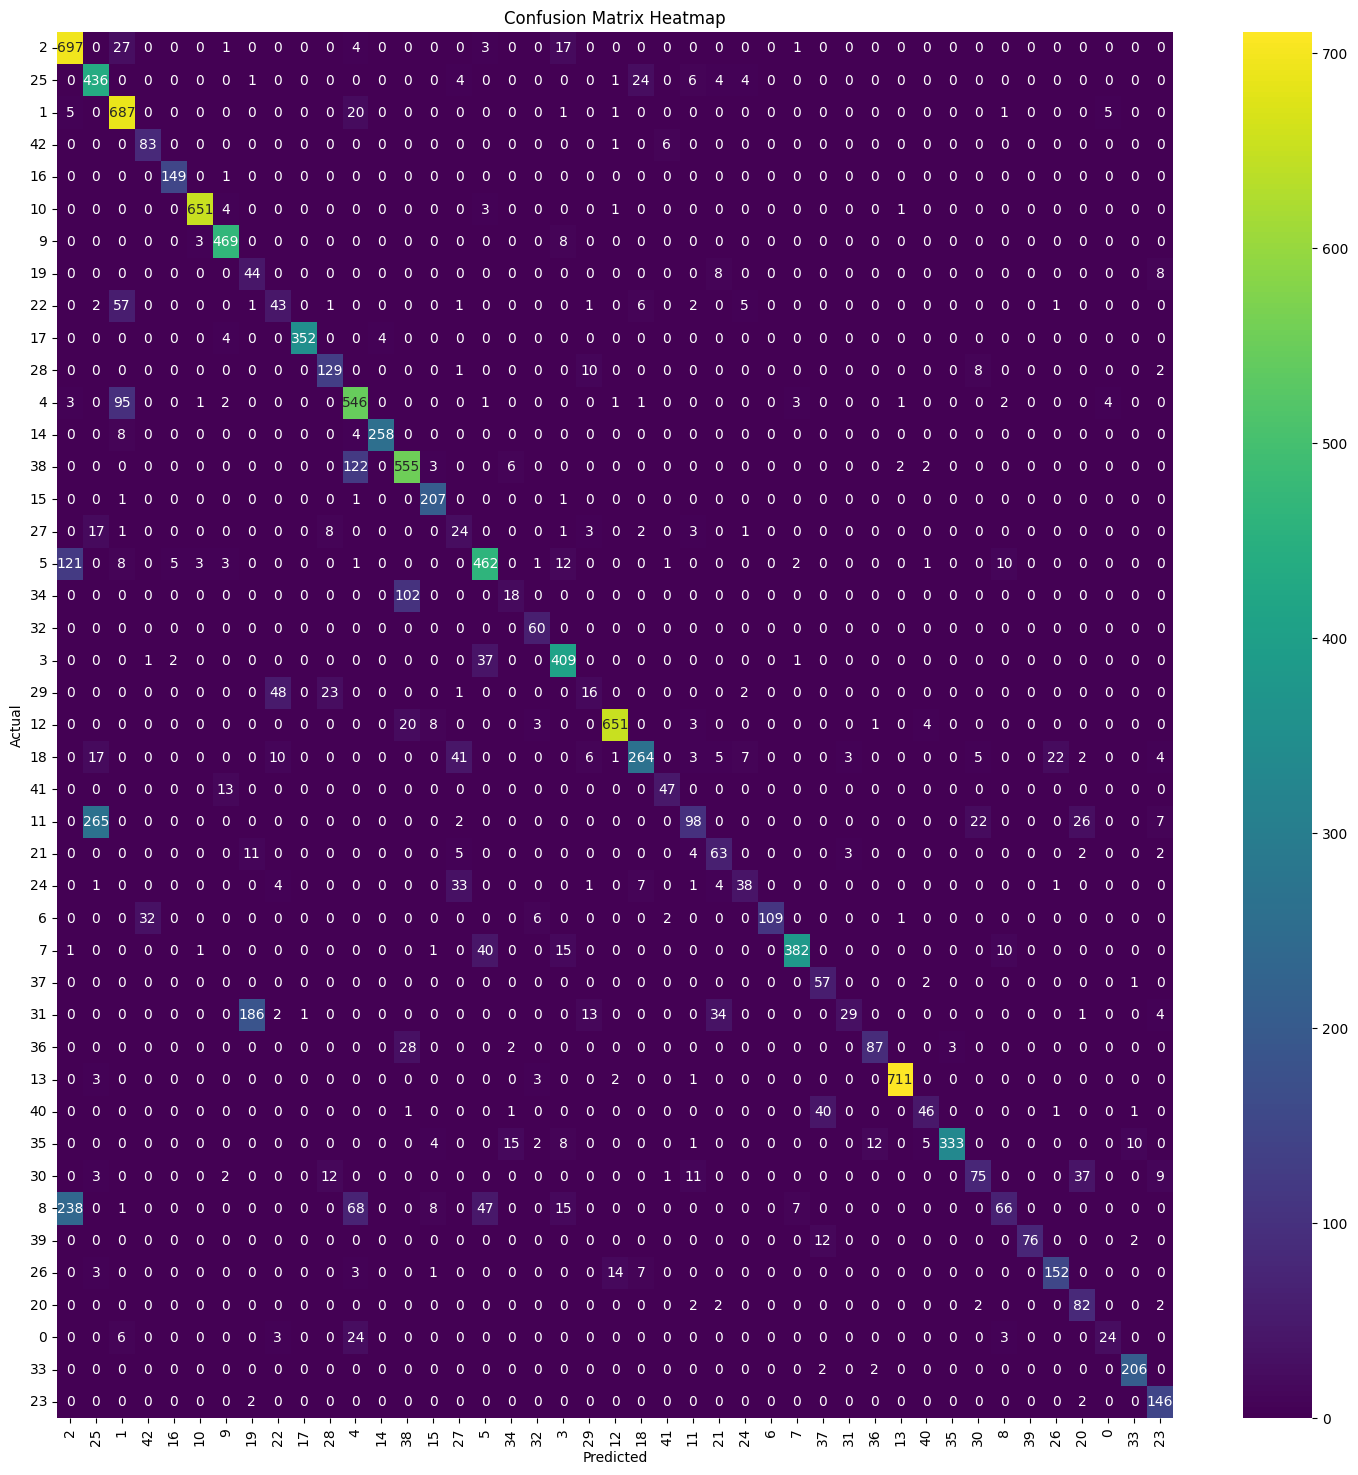

-Test Accuracy: 79.47%
-Train Accuracy: 84.56%
-Accuracy by validation: 85.49%
-Test F1 Macro: 0.71
-Test MCC: 0.79


In [29]:
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(18,18))
heatmap = sns.heatmap(conf_mat, vmin=np.min(conf_mat.all()), vmax=np.max(conf_mat), annot=True, fmt='d',cmap='viridis')
heatmap.set_title('Confusion Matrix Heatmap')
heatmap.set_xlabel('Predicted')
heatmap.set_ylabel('Actual')
heatmap.set_xticklabels(class_names, rotation=90)
heatmap.set_yticklabels(class_names, rotation=0)
plt.show()

print('-Test Accuracy: {:.2f}%\n-Train Accuracy: {:.2f}%\n-Accuracy by validation: {:.2f}%\n-Test F1 Macro: {:.2f}\n-Test MCC: {:.2f}'.
      format(accuracy_score(y_test,y_pred)*100,(history.history['accuracy'][-1])*100,(history.history['val_accuracy'][-1])*100, f1_score(y_test,y_pred, average='macro'), matthews_corrcoef(y_test,y_pred)))

## Visualize errors

In [30]:
index=0
index_errors= []

for label, predict in zip(y_test,y_pred):
    if label != predict:
        index_errors.append(index)
    index += 1

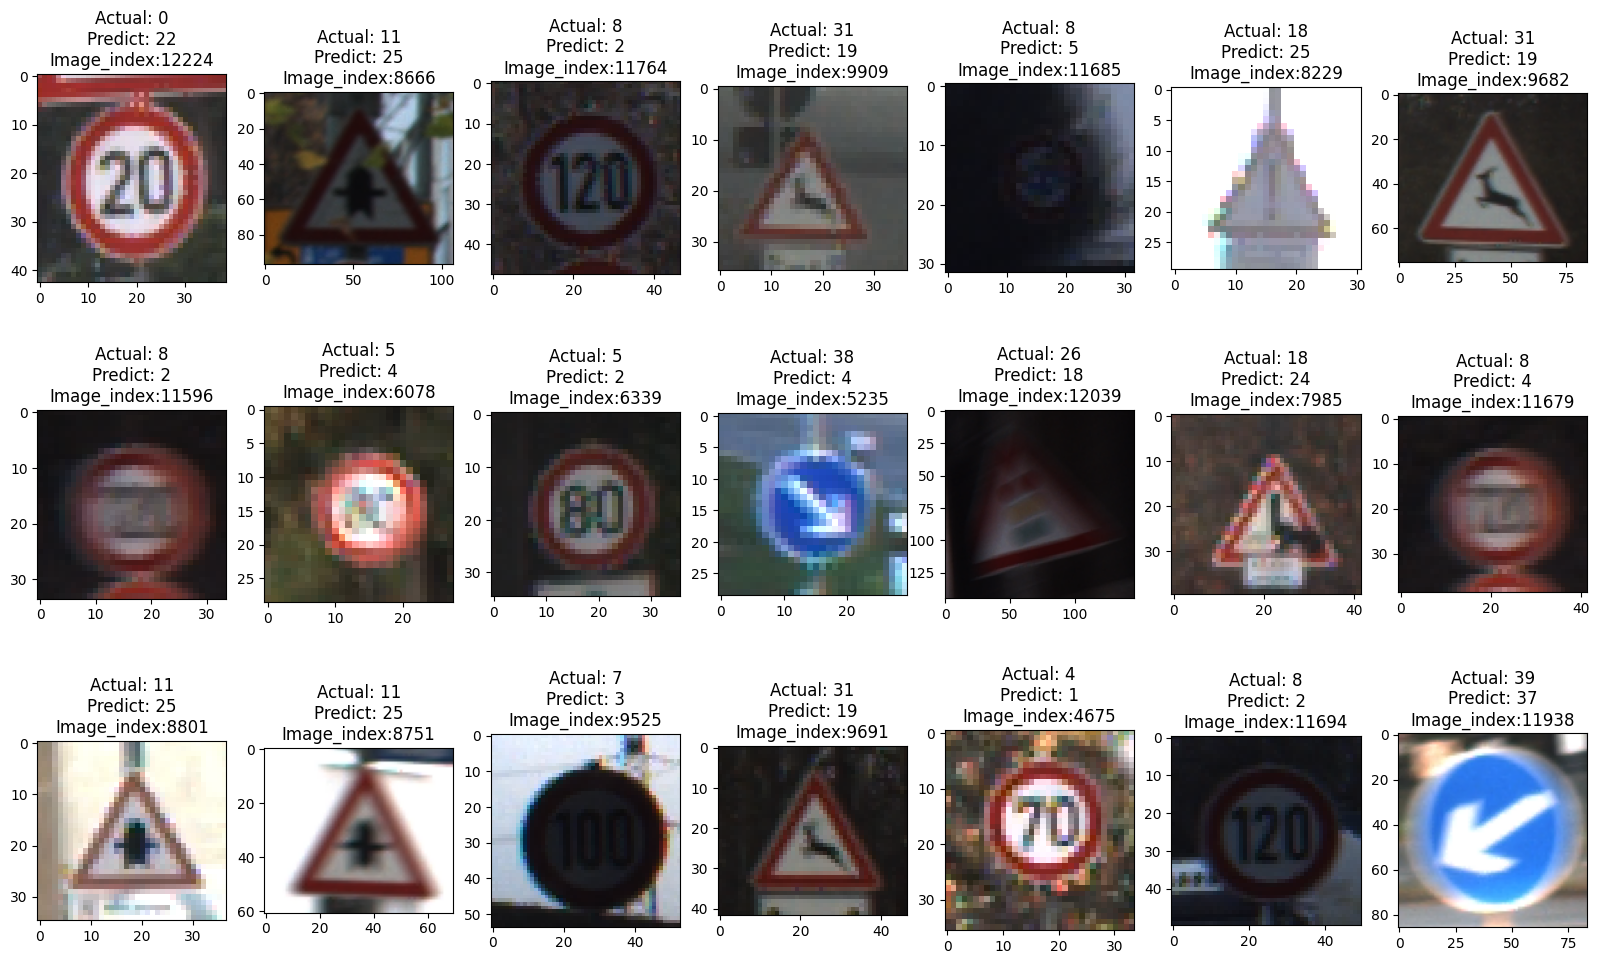

In [31]:
plt.figure(figsize=(20,12))

for i,img_index in zip(range(1,22),random.sample(index_errors,k=21)):
    plt.subplot(3,7,i)
    img_read = plt.imread(test_gen.filepaths[img_index])
    plt.imshow(img_read)
    plt.title('Actual: '+str(class_names[y_test[img_index]])+'\nPredict: '+str(class_names[y_pred[img_index]])+'\nImage_index:'+str(img_index))
plt.show()